# Week 3: Learning Curves and More Training Techniques
This notebook demonstrates key training concepts for neural networks, including early stopping and regularization (L2 & Dropout) using Keras/TensorFlow on the MNIST dataset.

We will also introduce **learning curves** comparing loss and accuracy on training and **static validation sets**.  The use of validation metrics, as introduced in Module 3, is essential to access how well models will generalize to new data. 

## 1. Setup and Data Loading
Import necessary libraries and preprocess the MNIST dataset.

In [1]:
# Imports and global variables

import numpy as np
import os
import time
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay, PiecewiseConstantDecay


# utility code

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [2]:
# Check for available GPU
print("Available GPU:", tf.config.list_physical_devices('GPU'))

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Utility to print learning curves

results = {}

def plot_learning_curves(hist, 
                         title="Learning Curves", 
                         best_epoch=None,              # None = print absolute minimum val_loss point on both plots
                                                       # else assume is 0-based early stopping trigger point
                         verbose=True
                        ):

    val_losses = hist.history['val_loss']
    
    if best_epoch:
        min_val_epoch = best_epoch
    else:
        min_val_epoch = val_losses.index(min(val_losses))
        
    val_loss_at_min_loss = hist.history['val_loss'][min_val_epoch]    
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]
    

    n_epochs = len(val_losses)
    epochs = list(range(1, n_epochs + 1))

    # Determine tick interval and xticks starting from 0

    tick_interval = max(1, n_epochs // 20)
    xticks = list(range(0, n_epochs + 1, tick_interval))

    plt.figure(figsize=(8, 8))

    # --- Loss Plot ---
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist.history['loss'], label='Train Loss')
    plt.plot(epochs, hist.history['val_loss'], label='Val Loss')
    plt.scatter(min_val_epoch + 1, val_loss_at_min_loss, color='red', marker='x', s=50, label='Min Val Loss') 
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(2, 1, 2)
    plt.plot(epochs, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, hist.history['val_accuracy'], label='Val Accuracy')
    plt.scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='Acc @ Min Val Loss')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1.05)
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {val_loss_at_min_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss, min_val_epoch + 1)

In [4]:
# Globals

epochs = 200
batch_size = 128

def train_and_test(model, 
                   epochs        = epochs,                 # Just needs to be bigger than early stop point
                   lr_schedule   = 0.0001,                  # Default for Adam.
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = batch_size, 
                   use_early_stopping = True,
                   patience      = 10,                     # To turn off early stopping, set patience to same as epochs
                   min_delta     = 0.0001,                 # We only look at first 4 digits after decimal point
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"{title}:  ",end='')
    # If parameters are not at defaults given above, print them out

    if lr_schedule != 0.001:
        print(f'lr_schedule: {lr_schedule}', end='')
    if batch_size != 128:
        print(f'\tbatch_size: {batch_size}', end='')
    if patience != 10:
        print(f'\tpatience: {patience}', end='')
    if min_delta != 0.0001:
        print(f'\tmin_delta: {min_delta}', end='')
    if callbacks != []:
        print(f'\tcallbacks: {callbacks}', end='')
    print('\n')

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]


    
    # Plot training history
    plot_learning_curves(history, title=title, best_epoch = best_epoch)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=verbose)
    
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Preparing Images for Deep Learning

In Week 14 of Module 3, we began our exploration of deep learning using the MNIST dataset of handwritten digits—a widely used benchmark often referred to as the *“Hello World”* of deep learning. When working with image data, two key preprocessing steps are essential.

#### Reshaping: From 2D Image to 1D Vector

Neural networks require inputs to be floating-point vectors. Since images are stored as 2D grids of pixel values, we need to reshape each image into a 1D array:

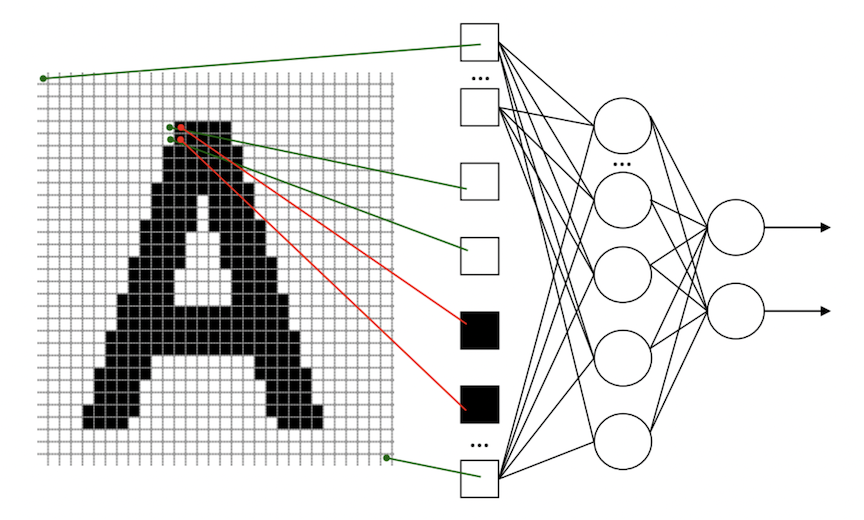

This reshaping can be done manually during preprocessing or automatically using a `Flatten()` layer in the model. Preprocessing is more efficient, so we’ll use generally that approach in this course.

#### Rescaling Pixel Values

Rather than standardizing pixel values (subtracting the mean and dividing by the standard deviation), we **rescale** them from their original range $[0, 255]$ to a normalized range $[0, 1)$.

Rescaling is preferred for image data because:

* It ensures all inputs fall within a **bounded, consistent range**, improving training stability (as standardization does for numeric data).
* Non-negative inputs are more compatible with activation functions like ReLU.
* It avoids altering the image’s appearance and structure, which standardization might distort.
* It requires no dataset-specific statistics, making it simpler and more robust.



In [5]:
# Load and preprocess MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten 28x28 images into 784-element vectors and rescale pixel values with a simple division
X_train = X_train.reshape(-1, 784).astype('float32') / 255.0
X_test  = X_test.reshape(-1, 784).astype('float32')  / 255.0

# One-hot encode the labels
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


#### Why One-Hot Labels?

One-hot labels are useful because they represent class membership in a format that aligns with the output of softmax layers, allowing the model to compute classification loss efficiently using categorical crossentropy.

Let's look at a few images to get a feel for the dataset....

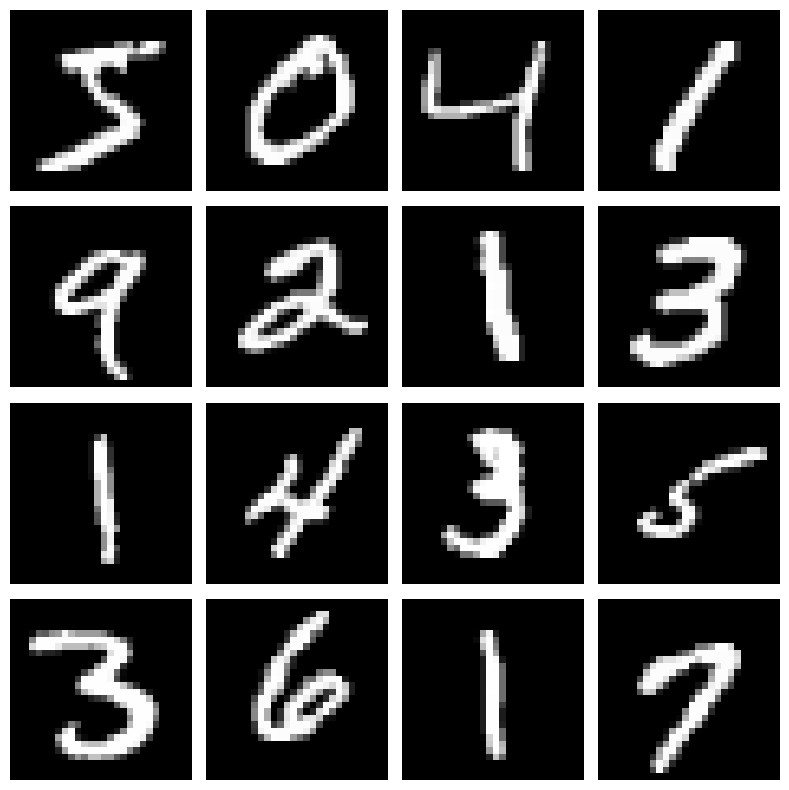

In [6]:
import matplotlib.pyplot as plt

# Display a 4x4 grid of MNIST images without labels
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')  # No labels

plt.tight_layout()
plt.show()


#### Here are the "one-hot" labels for these images

In [7]:
import numpy as np

# Print the one-hot encoded labels in 4x4 grid format
print("One-hot labels for the 4x4 grid of images:")
for i in range(4):
    row = y_train[i*4:(i+1)*4]
    for label in row:
        print(label.tolist(), "=", np.argmax(label.tolist()))
    print()  # Newline after each row


One-hot labels for the 4x4 grid of images:
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] = 5
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 4
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] = 9
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 2
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 1
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 3

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 1
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 4
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 3
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] = 5

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] = 6
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] = 1
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0] = 7



#### Global Variables

In [8]:
epochs = 200                    # With early stopping, this is less critical
batch_size = 128                # Dataset is large so we'll use a larger batch
learning_rate = 1e-03           # default for Adam

## 2. Baseline Model 
We'll define a simple model and plot learning curves (training vs validation loss & accuracy).

Since we want to try a bunch of different models, let's write a function to build them based on hyperparameters. 


In [9]:
def build_model(width=512, 
                activation= 'sigmoid',                  # defaults
                kernel_initializer='glorot_uniform',     
                l2_lambda = 0.0, 
                dropout_rate=0.0, 
                lr=learning_rate              # defined globally
               ):
    
    model = models.Sequential([
                                layers.Input(shape=(X_train.shape[1],)), 
                                layers.Dense(width, 
                                             activation=activation,       
                                             kernel_initializer=kernel_initializer,     
                                             kernel_regularizer=regularizers.l2(l2_lambda)
                                            ),     
                                layers.Dropout(dropout_rate),                                 
                                layers.Dense(num_classes, activation='softmax') 
                              ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

base_model = build_model()
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

#### Training with Validation Split

Unlike the cross-validation approach used in Module 3, this week's lesson introduces the more common practice of using a **static validation set.** In Keras, this set is automatically created when you specify a validation_split in the fit() method. The split is computed once before training begins and remains fixed throughout all epochs.


Baseline Model:  lr_schedule: 0.0001	batch_size: 128



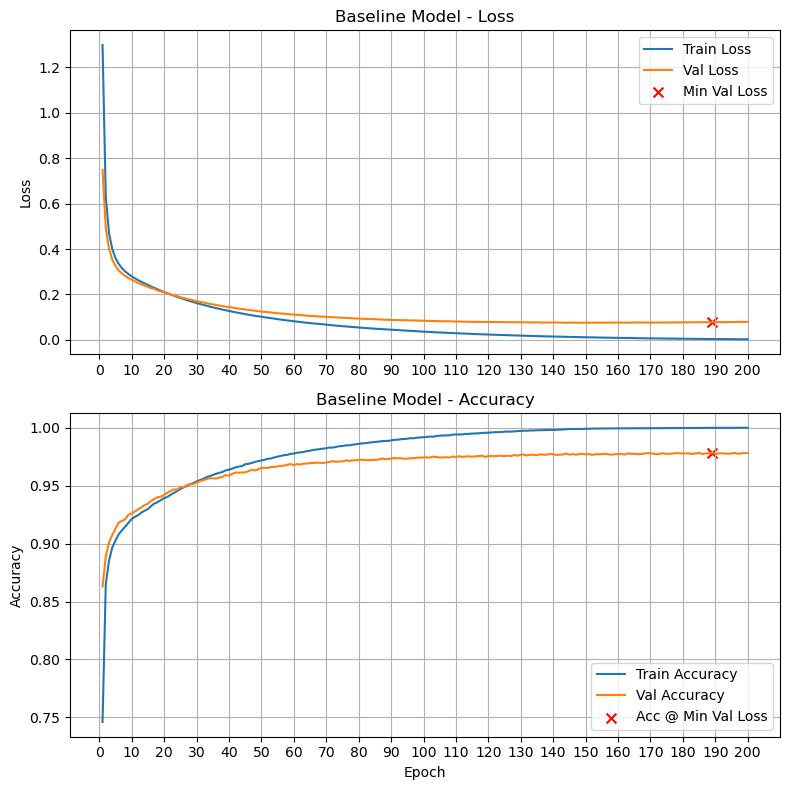

Final Training Loss:            0.0029
Final Training Accuracy:        0.9999
Final Validation Loss:          0.0794
Final Validation Accuracy:      0.9782
Minimum Validation Loss:        0.0784 (Epoch 189)
Validation Accuracy @ Min Loss: 0.9786

Test Accuracy: 0.9784
Test Loss: 0.0742

Validation-Test Gap (accuracy): 0.000183

Execution Time: 00:10:28


In [10]:

# base_model = build_model(lr=lr_schedule)
base_model = build_model(lr=learning_rate)               # no LR scheduling

train_and_test(base_model, lr_schedule = 0.0001, use_early_stopping=False,title="Baseline Model")

## 3. Early Stopping using Callbacks

This is a technique to stop training when validation loss stops improving, and is implemented
using a **callback**.

> In Keras, a **callback** is a function or object that runs at specific stages of training (such as after each epoch or batch) to monitor progress, modify training behavior, or perform side tasks like saving checkpoint models, adjusting learning rates, or saving statistics to a CSV file.

#### Early Stopping

Early stopping monitors a metric and halts training if the metric does not show `min_delta` improvement for `patience` epochs.
If `restore_best_weights=True` then the model returned by `fit` has been "rolled back" to the "best" epoch--beyond which no improvement was seen. A typical definition (which we have built into our `train_and_test` wrapper function) would be:

```python
    early_stop = EarlyStopping( monitor              = 'val_loss',
                                patience             = 5,                 # Typical values are 3 - 10
                                min_delta            = 0.0001,            # typical values 1e-3 to 1e-5
                                restore_best_weights = True,
                                verbose              = 0                  # Announce when
                              )
```

See the **Appendix** for a list of useful callbacks. 

#### Should we monitor validation loss or a metric such as validation accuracy in Early Stopping?

**The common practice is to monitor validation loss.**  

Why?

- Loss is the objective being minimized: it reflects the model’s raw error and is typically smoother and more sensitive to change than accuracy.
- Accuracy is discrete: it can be jumpy and plateau even if the model is still improving (e.g., via more confident predictions).
- It is a better indicator of generalization: a rising `val_loss` often signals overfitting before `val_accuracy` declines.

#### When should we use Early Stopping?

Early stopping is most useful **after** you've tuned your model to the point where the **validation curve is smooth and stable**. That means you've chosen:

* An appropriate **learning rate** (or schedule)
* A suitable **model architecture** (e.g., depth and width)
* Effective **regularization** (e.g., dropout, L2)

Once these pieces are in place, early stopping becomes a **reliable safety net**: it monitors validation performance and halts training as soon as the model **stops improving**, preventing overfitting and unnecessary computation.

In earlier stages of model tuning, the validation loss may fluctuate due to:

* Poor learning rate (too high or low)
* Noisy training curves (e.g., small batch size or poor regularization)
* Inappropriate model capacity

In these cases, early stopping might trigger **too soon**, cutting off learning before the model has had a chance to converge. That’s why it’s best used **after** you're close to finding a setup that produces consistently improving validation performance.


#### In short:

> **Use early stopping when you're confident your model is capable of generalizing — and you want to stop just before it starts to overfit.**




### Training and Testing Wrapper Code with Early Stopping 

We now define a useful wrapper function for running models and reporting results. We'll use early stopping
as the normal procedure from now on!

Baseline with Early Stopping:  lr_schedule: 0.0001	batch_size: 128



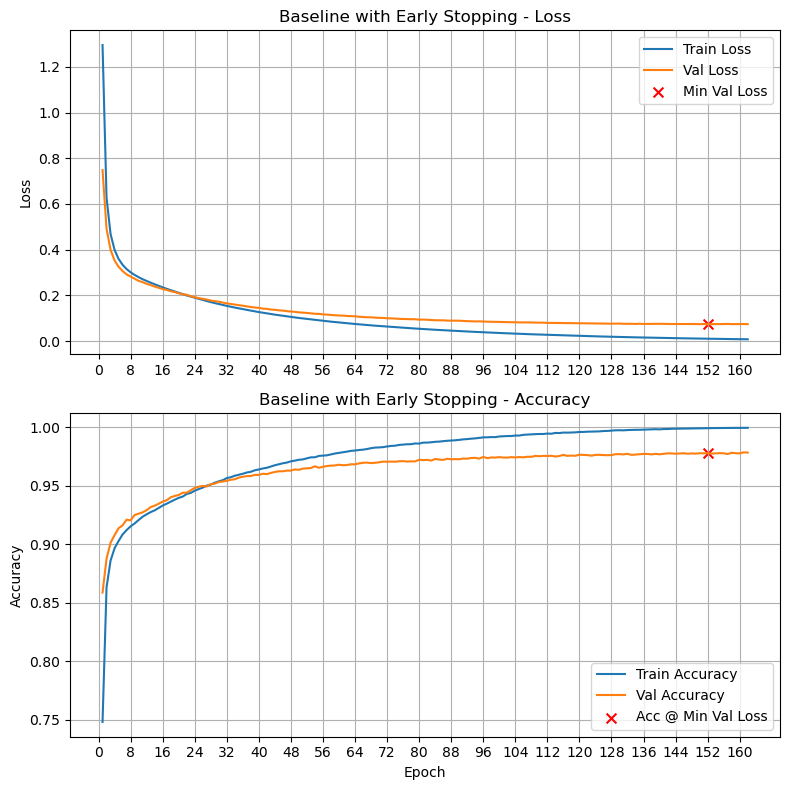

Final Training Loss:            0.0082
Final Training Accuracy:        0.9994
Final Validation Loss:          0.0745
Final Validation Accuracy:      0.9783
Minimum Validation Loss:        0.0742 (Epoch 152)
Validation Accuracy @ Min Loss: 0.9779

Test Accuracy: 0.9788
Test Loss: 0.0689

Validation-Test Gap (accuracy): 0.000883

Execution Time: 00:08:49


In [11]:
model_es = build_model(lr=learning_rate)  

train_and_test(model_es, title="Baseline with Early Stopping")


## 4. Different widths

We'll try 4 different widths for the hidden layer: 32, 256, 1024, 2048. Our baseline already has 512. 


Hidden Width 32:  lr_schedule: 0.0001	batch_size: 128



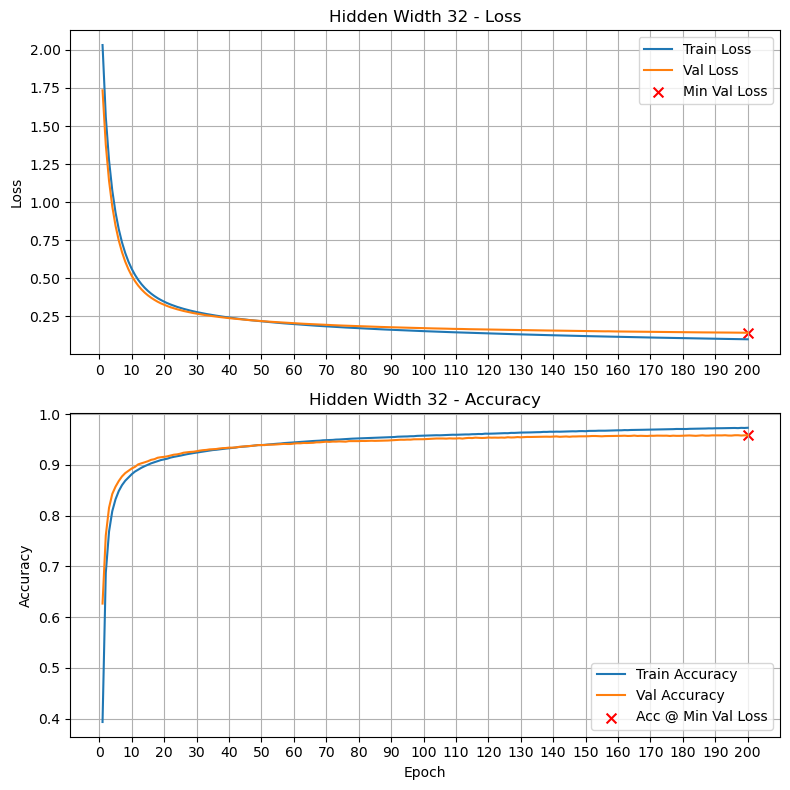

Final Training Loss:            0.0987
Final Training Accuracy:        0.9732
Final Validation Loss:          0.1416
Final Validation Accuracy:      0.9583
Minimum Validation Loss:        0.1416 (Epoch 200)
Validation Accuracy @ Min Loss: 0.9583

Test Accuracy: 0.9584
Test Loss: 0.1369

Validation-Test Gap (accuracy): 0.000067

Execution Time: 00:10:03


In [12]:
model_32 = build_model(width=32)

train_and_test(model_32,title="Hidden Width 32")

Hidden Width 256:  lr_schedule: 0.0001	batch_size: 128



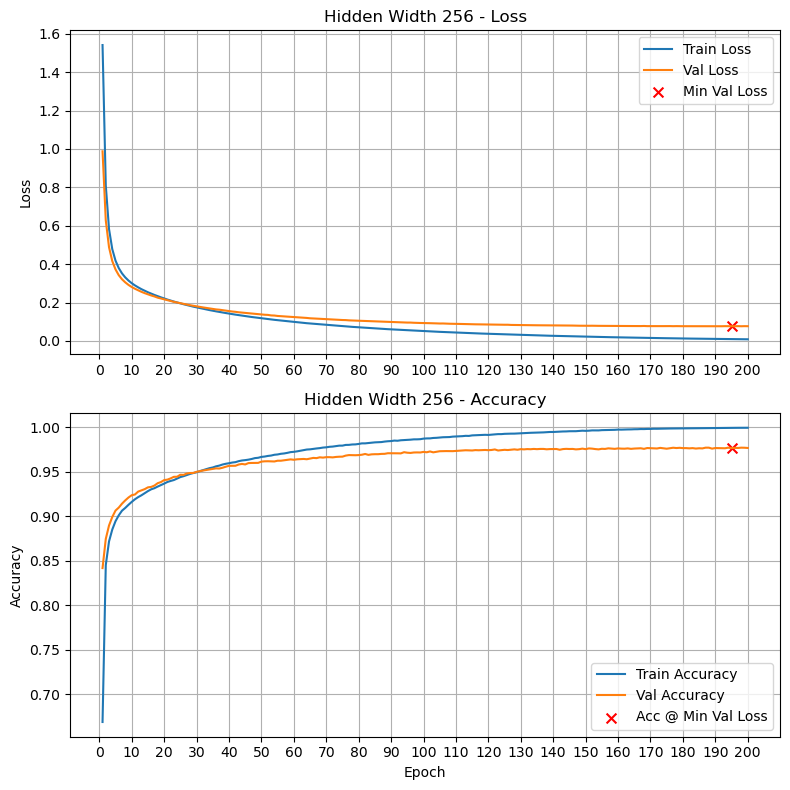

Final Training Loss:            0.0085
Final Training Accuracy:        0.9996
Final Validation Loss:          0.0767
Final Validation Accuracy:      0.9769
Minimum Validation Loss:        0.0764 (Epoch 195)
Validation Accuracy @ Min Loss: 0.9768

Test Accuracy: 0.9793
Test Loss: 0.0706

Validation-Test Gap (accuracy): 0.002550

Execution Time: 00:10:04


In [13]:
model_256 = build_model(width=256)

train_and_test(model_256,title="Hidden Width 256")

Hidden Width 1024:  lr_schedule: 0.0001	batch_size: 128



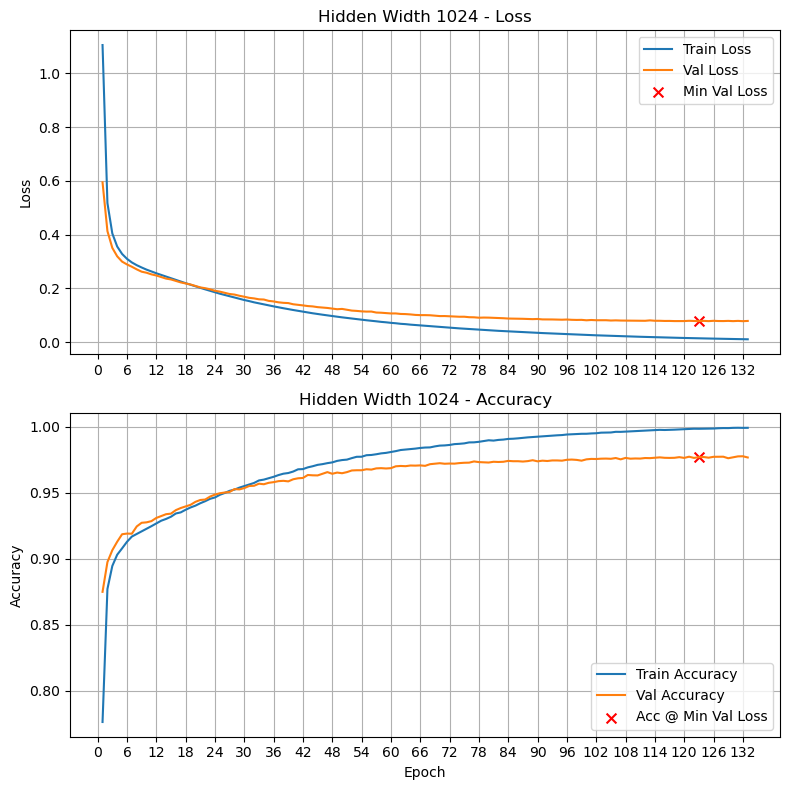

Final Training Loss:            0.0105
Final Training Accuracy:        0.9990
Final Validation Loss:          0.0788
Final Validation Accuracy:      0.9766
Minimum Validation Loss:        0.0779 (Epoch 123)
Validation Accuracy @ Min Loss: 0.9768

Test Accuracy: 0.9799
Test Loss: 0.0723

Validation-Test Gap (accuracy): 0.003067

Execution Time: 00:06:42


In [14]:
model_1024 = build_model(width=1024)

train_and_test(model_1024,title="Hidden Width 1024")

Hidden Width 2048:  lr_schedule: 0.0001	batch_size: 128



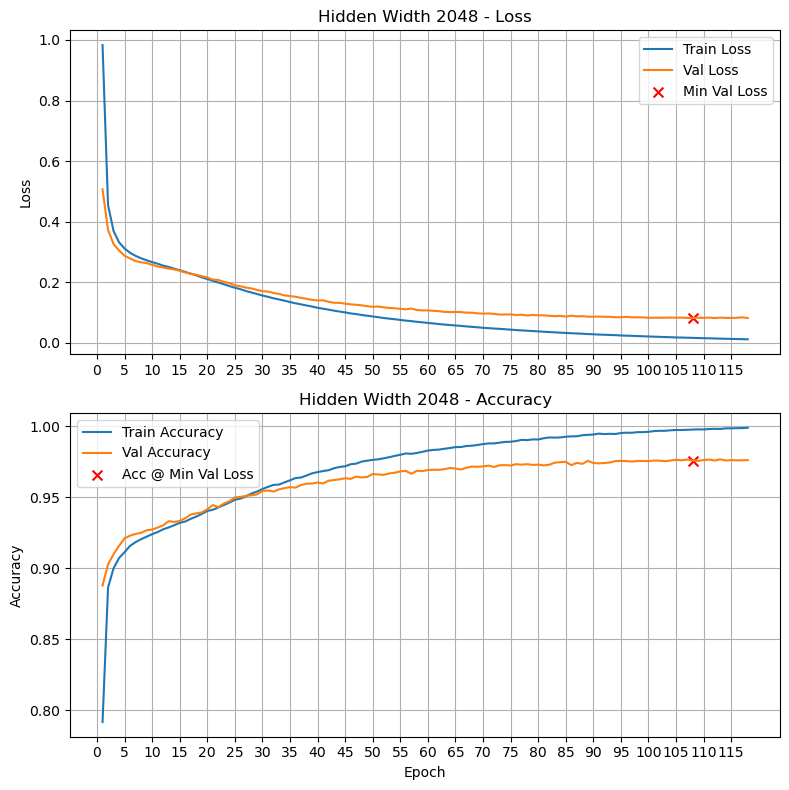

Final Training Loss:            0.0114
Final Training Accuracy:        0.9989
Final Validation Loss:          0.0818
Final Validation Accuracy:      0.9761
Minimum Validation Loss:        0.0813 (Epoch 108)
Validation Accuracy @ Min Loss: 0.9758

Test Accuracy: 0.9787
Test Loss: 0.0763

Validation-Test Gap (accuracy): 0.002867

Execution Time: 00:06:03


In [15]:
model_2048 = build_model(width=2048)

train_and_test(model_2048,title="Hidden Width 2048")

Hidden Width 4096:  lr_schedule: 0.0001	batch_size: 128



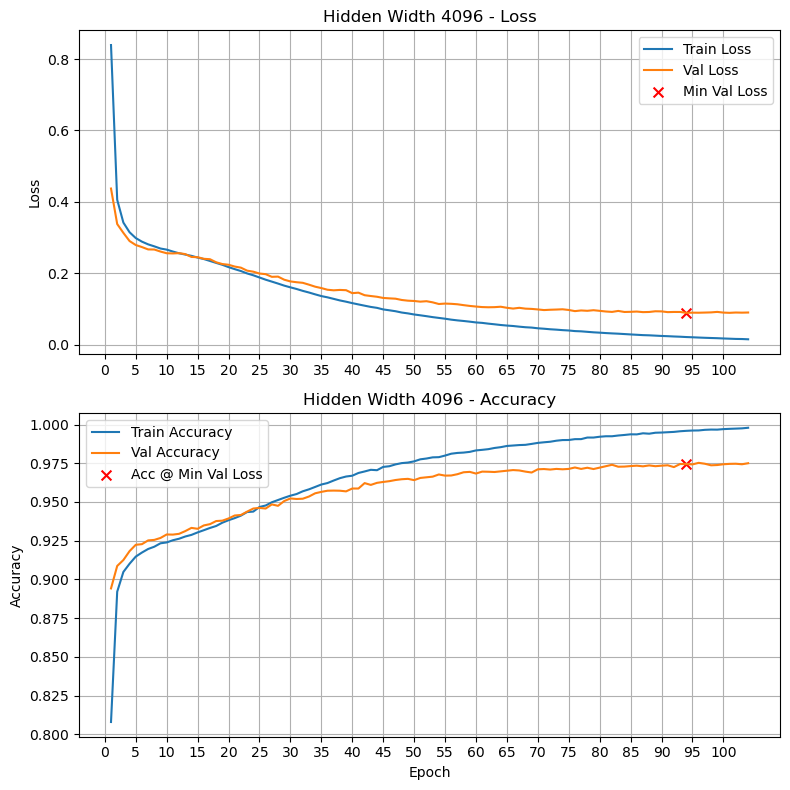

Final Training Loss:            0.0146
Final Training Accuracy:        0.9979
Final Validation Loss:          0.0897
Final Validation Accuracy:      0.9750
Minimum Validation Loss:        0.0888 (Epoch 94)
Validation Accuracy @ Min Loss: 0.9744

Test Accuracy: 0.9763
Test Loss: 0.0826

Validation-Test Gap (accuracy): 0.001883

Execution Time: 00:05:32


In [16]:
model_4096 = build_model(width=4096)

train_and_test(model_4096,title="Hidden Width 4096")

## 4. Activations and Weight Initialization

We'll try four experiments with the MNIST dataset:

- Baseline with sigmoid    (ha, already done above!)
- Baseline with tanh
- Baseline with ReLU
- Baseline with ReLU and HE initialization

The first three use the `'glorot_uniform'` initialization strategy, which is recommended for sigmoid and tanh. We'll try
ReLU with the default and also with `'he_normal'`. ReLU is supposed to work better with `'he_normal'`.  Let's find out!

Tanh Activation:  lr_schedule: 0.0001	batch_size: 128



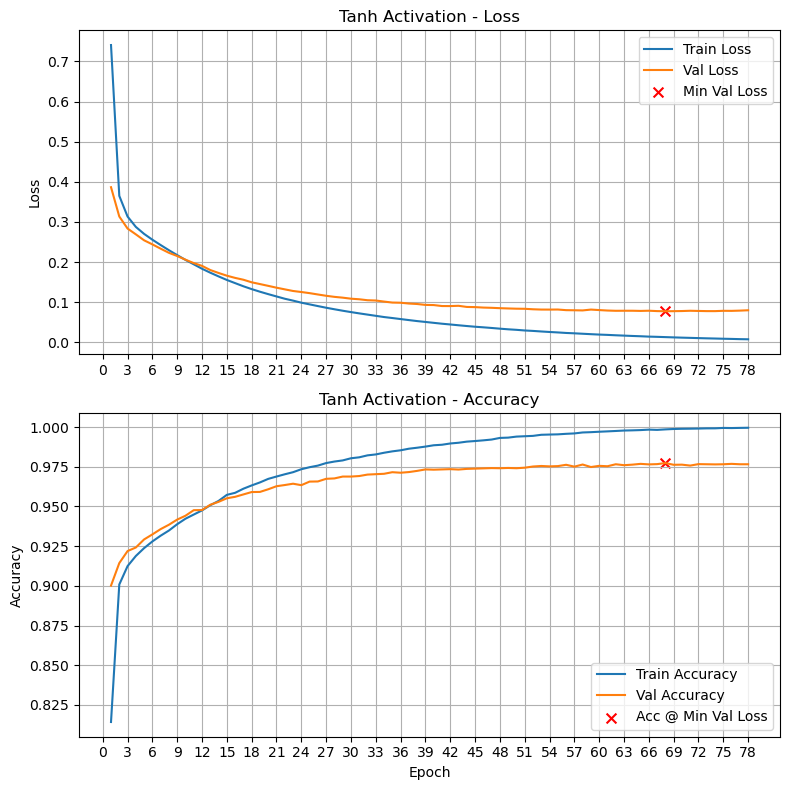

Final Training Loss:            0.0079
Final Training Accuracy:        0.9996
Final Validation Loss:          0.0801
Final Validation Accuracy:      0.9766
Minimum Validation Loss:        0.0776 (Epoch 68)
Validation Accuracy @ Min Loss: 0.9773

Test Accuracy: 0.9785
Test Loss: 0.0727

Validation-Test Gap (accuracy): 0.001167

Execution Time: 00:04:02


In [17]:
# Build model with scheduled learning rate and L2 regularization

act_model1 = build_model(activation= 'tanh')

train_and_test(act_model1,title="Tanh Activation")

ReLU Activation:  lr_schedule: 0.0001	batch_size: 128



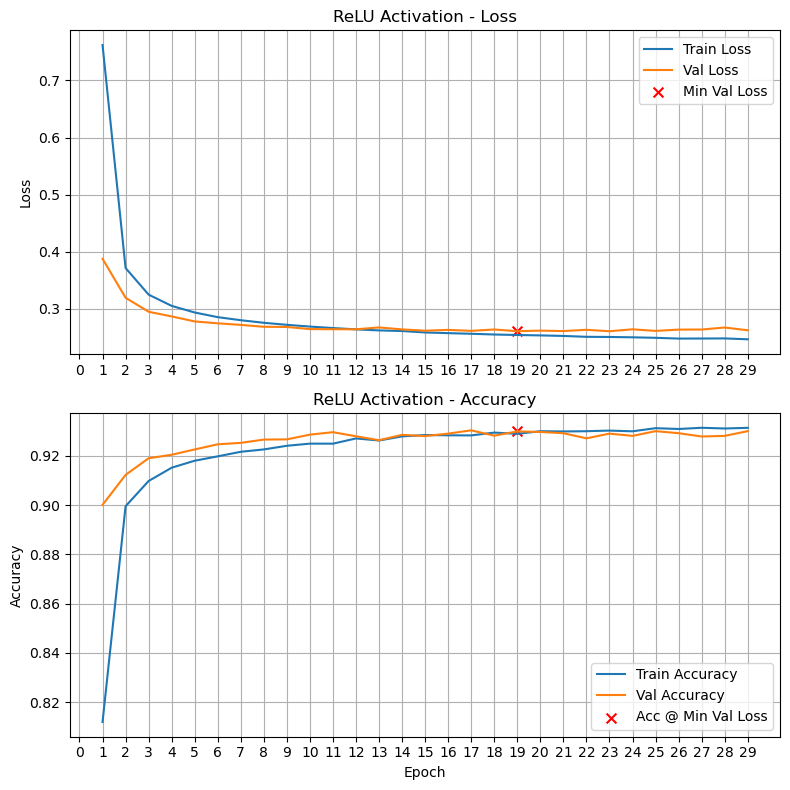

Final Training Loss:            0.2470
Final Training Accuracy:        0.9314
Final Validation Loss:          0.2628
Final Validation Accuracy:      0.9300
Minimum Validation Loss:        0.2611 (Epoch 19)
Validation Accuracy @ Min Loss: 0.9299

Test Accuracy: 0.9272
Test Loss: 0.2661

Validation-Test Gap (accuracy): 0.002717

Execution Time: 00:01:30


In [18]:
act_model2 = build_model(activation= 'relu')

train_and_test(act_model2,title="ReLU Activation")

ReLU + HE Initializer:  lr_schedule: 0.0001	batch_size: 128



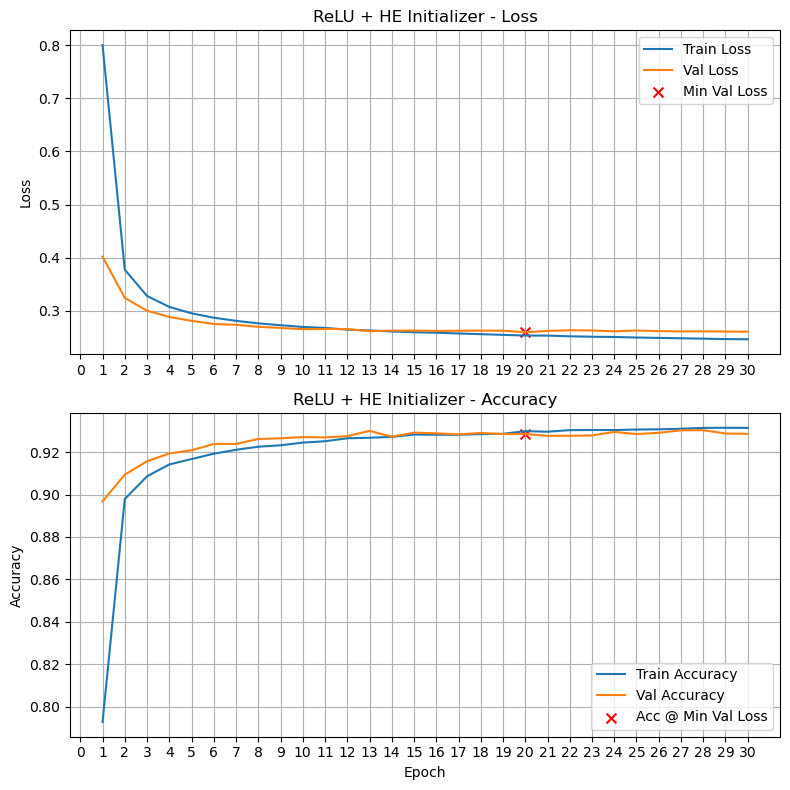

Final Training Loss:            0.2467
Final Training Accuracy:        0.9315
Final Validation Loss:          0.2611
Final Validation Accuracy:      0.9287
Minimum Validation Loss:        0.2601 (Epoch 20)
Validation Accuracy @ Min Loss: 0.9286

Test Accuracy: 0.9263
Test Loss: 0.2638

Validation-Test Gap (accuracy): 0.002283

Execution Time: 00:01:34


In [19]:
act_model3 = build_model(activation= 'relu', kernel_initializer='he_normal')

train_and_test(act_model3,title="ReLU + HE Initializer")

## 5. Regularization:  L2 and Dropout

We'll try three experiments with the MNIST dataset:

- Baseline plus L2 Regularization
- Baseline plus Dropout
- Baseline with Both

L2 Regularization Model:  lr_schedule: 0.0001	batch_size: 128



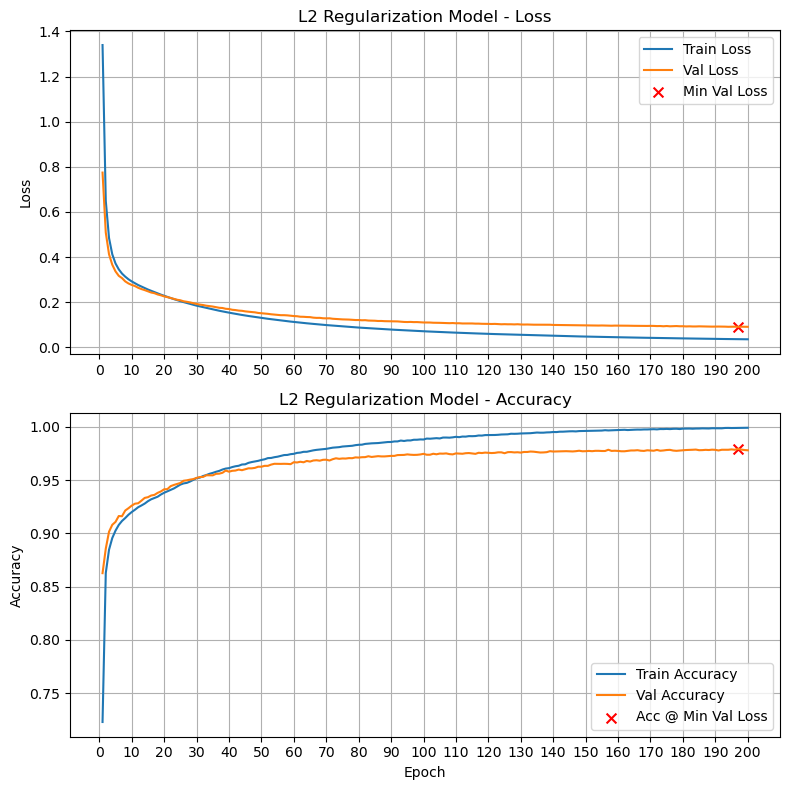

Final Training Loss:            0.0359
Final Training Accuracy:        0.9990
Final Validation Loss:          0.0912
Final Validation Accuracy:      0.9779
Minimum Validation Loss:        0.0911 (Epoch 197)
Validation Accuracy @ Min Loss: 0.9793

Test Accuracy: 0.9801
Test Loss: 0.0826

Validation-Test Gap (accuracy): 0.000767

Execution Time: 00:10:17


In [20]:
# Build model with scheduled learning rate and L2 regularization

L2_model = build_model(l2_lambda=1e-5, lr=learning_rate)

train_and_test(L2_model,title="L2 Regularization Model")

Dropout Model:  lr_schedule: 0.0001	batch_size: 128



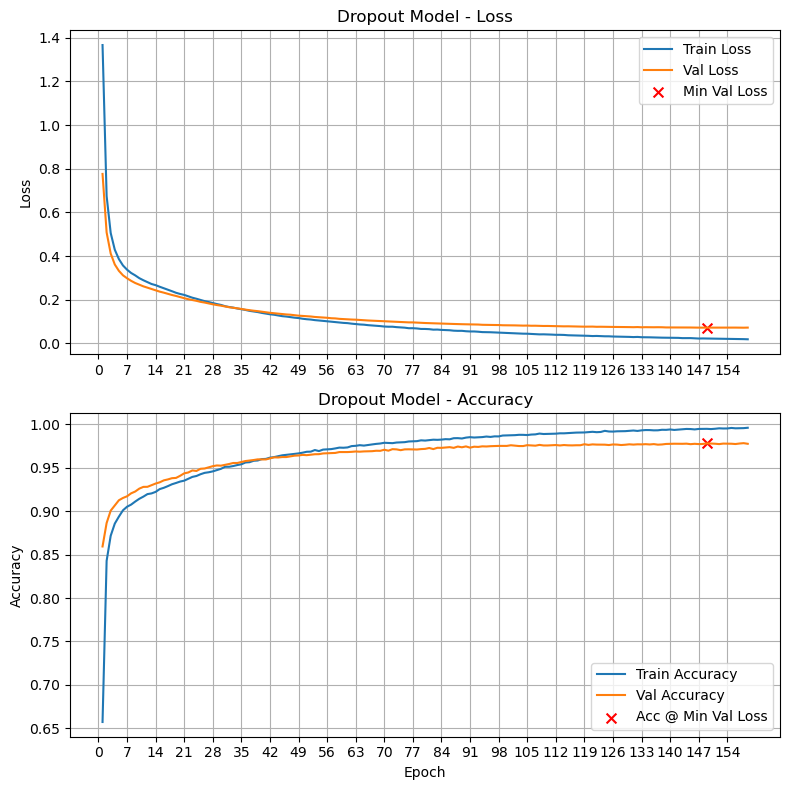

Final Training Loss:            0.0188
Final Training Accuracy:        0.9960
Final Validation Loss:          0.0723
Final Validation Accuracy:      0.9775
Minimum Validation Loss:        0.0719 (Epoch 149)
Validation Accuracy @ Min Loss: 0.9780

Test Accuracy: 0.9800
Test Loss: 0.0679

Validation-Test Gap (accuracy): 0.002000

Execution Time: 00:08:53


In [21]:
# Build model with scheduled learning rate and drop out
do_model = build_model(dropout_rate=0.15, lr=learning_rate)

do_history = train_and_test(do_model,title="Dropout Model")

Dropout and L2 Regularization Model:  lr_schedule: 0.0001	batch_size: 128



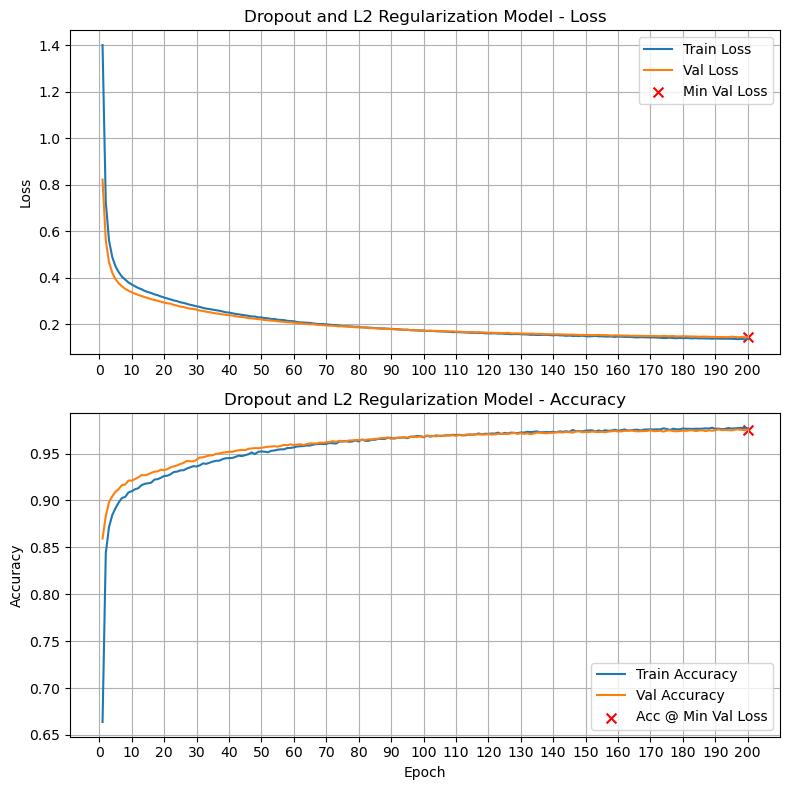

Final Training Loss:            0.1369
Final Training Accuracy:        0.9771
Final Validation Loss:          0.1449
Final Validation Accuracy:      0.9756
Minimum Validation Loss:        0.1449 (Epoch 200)
Validation Accuracy @ Min Loss: 0.9756

Test Accuracy: 0.9755
Test Loss: 0.1397

Validation-Test Gap (accuracy): 0.000083

Execution Time: 00:11:02


In [22]:
# Build model with scheduled learning rate and both L2 regularization and drop out
L2_do_model = build_model(l2_lambda=1e-4, dropout_rate=0.15, lr=learning_rate)

train_and_test(L2_do_model,title="Dropout and L2 Regularization Model")

### Comparison of All Models

In [28]:
# Print results sorted by accuracy (highest → lowest)
for title, (acc, ep) in sorted(results.items(), 
                               key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                               reverse=True):
    print(f"{title:<40}\t{acc:.4f} @ {ep}")

L2 Regularization Model                 	0.9793 @ 197
Baseline Model                          	0.9786 @ 189
Dropout Model                           	0.9780 @ 149
Baseline with Early Stopping            	0.9779 @ 152
Tanh Activation                         	0.9773 @ 68
Hidden Width 1024                       	0.9768 @ 123
Hidden Width 256                        	0.9768 @ 195
Hidden Width 2048                       	0.9758 @ 108
Dropout and L2 Regularization Model     	0.9756 @ 200
Hidden Width 4096                       	0.9744 @ 94
Hidden Width 32                         	0.9583 @ 200
ReLU Activation                         	0.9299 @ 19
ReLU + HE Initializer                   	0.9286 @ 20


#### Big Takeaway: Try everything, but pay attention to the activation!

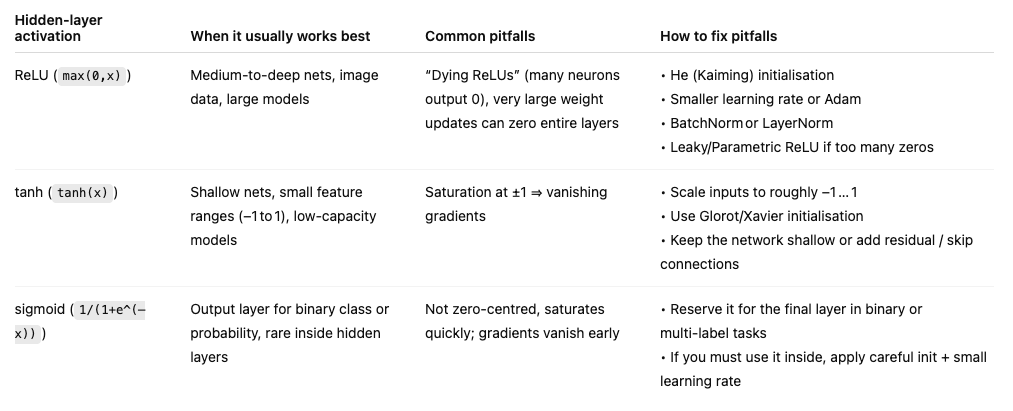


- ReLU is the first try for deep or medium networks, provided you couple it with He initialisation, a sensible LR, and (often) BatchNorm.

- Tanh can beat ReLU in very small or low‑capacity models because every neuron remains active.

- Sigmoid is best kept for binary outputs; inside hidden layers it is almost always replaced by tanh or ReLU family members today.

When in doubt, prototype with ReLU; if you see many dead activations or extremely slow convergence in a small model, switch to tanh (or LeakyReLU) and retest.

### Appendix One: Recommended Callbacks


| Callback                  | What It Does                                                | Why Use It                                            |
|---------------------------|-------------------------------------------------------------|--------------------------------------------------------|
| **`EarlyStopping`**       | Stops training when validation performance stops improving  | Prevents overfitting; saves time                      |
| **`ModelCheckpoint`**     | Saves the model to disk during training                     | Keeps the best version of your model                  |
| **`ReduceLROnPlateau`**   | Lowers learning rate when validation loss plateaus          | Helps model continue improving when stuck             |
| **`TensorBoard`**         | Logs training progress for interactive visualization        | Lets you inspect loss, accuracy, etc. over time       |
| **`CSVLogger`**           | Saves loss and metric history to a CSV file                 | Easy to analyze training results in Excel or Pandas   |
| **`LearningRateScheduler`** | Manually adjust learning rate schedule per epoch         | For advanced tuning or warm-up strategies             |



#### Example: Combining multiple callbacks

```python
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    callbacks=callbacks_list
)
```



## Appendix Two: GPUs

### Why Use a GPU?

Deep learning models often involve millions of matrix and tensor operations. These are computationally expensive and can take a long time to run on a traditional CPU. **GPUs (Graphics Processing Units)** are designed to handle these kinds of parallel operations efficiently and can speed up training dramatically — especially for large datasets or deeper models.



### Using a GPU in Google Colab

**Google Colab** provides free access to GPUs, making it easy to experiment with deep learning without installing anything locally.

#### How to Enable a GPU in Colab

You don’t need to change your code to use a GPU — just enable it in the notebook settings:

1. Click **`Runtime`** in the top menu
2. Select **`Change runtime type`**
3. Set **Hardware accelerator** to **`GPU`**
4. Click **Save**

Colab will reconnect your session and automatically use the GPU for training.

#### Does TensorFlow Use the GPU Automatically?

Yes! If a GPU is available, **TensorFlow (and Keras)** will use it by default. You can verify which devices TensorFlow is using with:

```python
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)
```

If you're using a GPU, you’ll see messages indicating that operations are being placed on the GPU.



### Using a GPU on Your Own Machine

If you have a machine with a compatible GPU, TensorFlow/Keras can also take advantage of it — but **some setup may be required**, depending on your hardware.

#### If You Have an NVIDIA GPU (Windows/Linux/macOS with eGPU):

TensorFlow will only use your GPU **if the correct drivers and CUDA libraries are installed**:

1. Install the [NVIDIA GPU driver](https://www.nvidia.com/Download/index.aspx)
2. Install the [CUDA Toolkit and cuDNN](https://developer.nvidia.com/cuda-toolkit)
3. Make sure you install a TensorFlow version that supports GPU (e.g., `tensorflow==2.x`)
4. You can verify GPU access the same way as in Colab:

```python
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
```

> Note: Mismatched CUDA or cuDNN versions are a common source of installation issues.

#### If You Have an Apple Silicon Mac (M1, M2, etc.):

Apple's M-series chips include powerful **Neural Engine** and **GPU** cores, but standard TensorFlow does **not** use these automatically.

To use the GPU on Apple Silicon:

1. Install the **macOS version of TensorFlow with Metal support**:

   ```bash
   pip install tensorflow-macos tensorflow-metal
   ```
2. This version allows TensorFlow to run on the GPU through Apple’s Metal API.
3. Again, check with:

   ```python
   tf.config.list_physical_devices()
   ```

#### Do I Need to Change My Code?

**Usually not.** If TensorFlow is installed correctly and a compatible GPU is available, Keras will use it automatically. No need to rewrite your model code — but you might see faster training times.

However, you can explicitly place operations on the GPU if needed:

```python
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, ...)
```

This is optional — it's mainly useful for debugging or hybrid CPU-GPU workflows.



### Summary

| Platform                   | GPU Support?  | Additional Setup Needed?                      | Notes                             |
| -------------------------- | ------------- | --------------------------------------------- | --------------------------------- |
| Google Colab               | ✅             | No                                            | Easiest way to use a GPU          |
| Windows/Linux + NVIDIA GPU | ✅             | Yes (drivers + CUDA/cuDNN)                    | Make sure versions are compatible |
| Apple Silicon              | ✅ (via Metal) | Yes (`tensorflow-macos` & `tensorflow-metal`) | Needs special TensorFlow version  |

> Tip: If you're unsure whether your code is using the GPU, try training a small model and observe whether it's noticeably faster with GPU enabled.




In [24]:
import tensorflow as tf

# Check for available GPU
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Optional: Show where a tensor is stored
tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
print("Tensor is on device:", tensor.device)

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensor is on device: /job:localhost/replica:0/task:0/device:GPU:0


### Moving a Tensor Between CPU and GPU

In most cases, **you won’t need to move tensors manually** — when you use Keras to define and train models, TensorFlow automatically places operations on the GPU (in Colab or on your local machine) if one is available.

However, it’s helpful to understand how TensorFlow manages devices and how to **explicitly place tensors or operations on the CPU or GPU**, especially when debugging or optimizing more complex workflows. This is more common when working with **lower-level TensorFlow code** rather than the high-level Keras API.

For example, you can write:

```python
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0]])
```

Or move a tensor back to the CPU explicitly:

```python
with tf.device('/CPU:0'):
    b = tf.identity(a)
```

These techniques are useful if you're profiling performance, mixing device types, or encountering device placement errors.



In [25]:
'''
import tensorflow as tf

# Create a tensor on the CPU (default)
with tf.device('/CPU:0'):
    cpu_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    print("Created on:", cpu_tensor.device)

# Move tensor to GPU (if available)
if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        gpu_tensor = tf.identity(cpu_tensor)
        print("Moved to:", gpu_tensor.device)

    # Move back to CPU
    with tf.device('/CPU:0'):
        back_to_cpu = tf.identity(gpu_tensor)
        print("Moved back to:", back_to_cpu.device)
else:
    print("No GPU available – skipping GPU transfer.")
'''


'\nimport tensorflow as tf\n\n# Create a tensor on the CPU (default)\nwith tf.device(\'/CPU:0\'):\n    cpu_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])\n    print("Created on:", cpu_tensor.device)\n\n# Move tensor to GPU (if available)\nif tf.config.list_physical_devices(\'GPU\'):\n    with tf.device(\'/GPU:0\'):\n        gpu_tensor = tf.identity(cpu_tensor)\n        print("Moved to:", gpu_tensor.device)\n\n    # Move back to CPU\n    with tf.device(\'/CPU:0\'):\n        back_to_cpu = tf.identity(gpu_tensor)\n        print("Moved back to:", back_to_cpu.device)\nelse:\n    print("No GPU available – skipping GPU transfer.")\n'